In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 6.6 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 186 kB 54.8 MB/s 
     |████████████████████████████████| 1.2 MB 52.2 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 398 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
# get the relative path as the current path
Path.BASE_PATH = path
path

Path('.')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


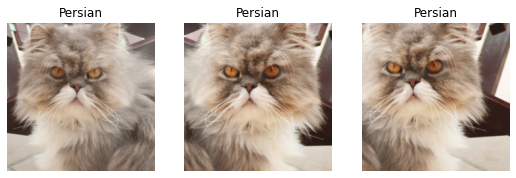

In [5]:
# get the data loader for the model

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter = RandomSplitter(seed=8),
                 get_y = using_attr(RegexLabeller("(.+)_\d+\.jpg"), "name"),
                 item_tfms = Resize(460),
                 batch_tfms = aug_transforms(size=224, min_scale=0.75)
                 )

pet_loader = pets.dataloaders(path/'images')

pet_loader.show_batch(nrows=1, ncols=3, unique=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.0003981071640737355)

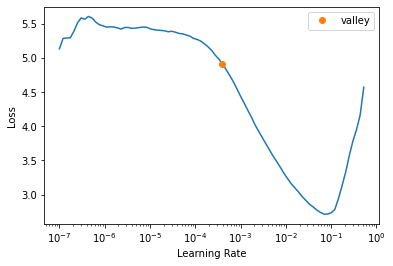

In [6]:
# create a cnn learner and find optimal learning rate for the first few layers
# used mixed fp 16 to speed up training of the deeper network]
from fastai.callback.fp16 import *
learn = cnn_learner(pet_loader, resnet50, metrics=error_rate).to_fp16()
# freeze the model to find optimal learning rate for inital frozen training
learn.freeze()
learn.lr_find()

In [8]:
# call fit one cycle for 2 epochs with the learning rate found
learn.fit_one_cycle(2, lr_max=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.953009,0.232881,0.075778,01:09
1,0.427577,0.188748,0.065629,01:09


SuggestedLRs(valley=1.4454397387453355e-05)

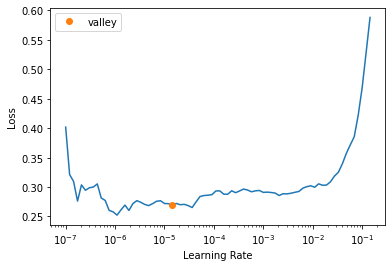

In [22]:
# unfreeze the model and pass a slice of values into lr_find to find optimal learning rate
learn.unfreeze()
learn.lr_find()

In [23]:
# use lr/100 and lr as part of the values in the slice above
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.270168,0.186798,0.064953,01:10
1,0.283135,0.186398,0.064276,01:10
2,0.289746,0.185671,0.061570,01:10
3,0.275670,0.191819,0.060217,01:10
4,0.273385,0.189356,0.061570,01:10
5,0.295170,0.184546,0.061570,01:11


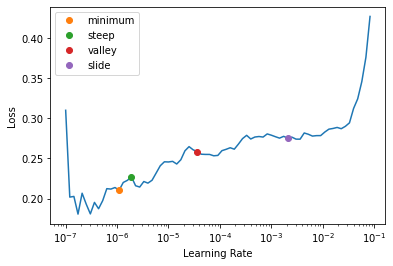

In [24]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [25]:
lr_min

1.0964781722577755e-07

In [26]:
# fit one final time for 3 epochs
learn.fit_one_cycle(3, lr_max=slice(1e-9, 1e-7))

epoch,train_loss,valid_loss,error_rate,time
0,0.270470,0.188239,0.061570,01:11
1,0.275071,0.187172,0.059540,01:11
2,0.274594,0.190780,0.065629,01:11


In [ ]:
# notice we are starting to overfit, so stop here